# DEUXIÈME CYCLE

In [74]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, matthews_corrcoef
import argparse
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

Dans ce deuxième cycle, nous utiliserons le fichier de données data_V2.csv dans lequel nous avons regroupé les modalités les plus faiblement représentées ainsi que les valeurs manquantes "?" et où nous avons recodé les variables quantitatives $\textbf{age}$ et $\textbf{hours-per-week}$ en classes optimisées par rapport à la variable $\textbf{income}$ (code disponible dans optimisation_classes.py).

Une majorité des fonctions que nous allons utilisées dans cette partie sont les mêmes que dans le premier cycle. Nous allons simplement mettre à jour les fonctions Logistic_Regression_V1 et DecisionTree_V1 en V2 et V3 afin de les adapter aux nouvelles spécifications. De plus, nous introduirons la fonction GrilleRecherche qui utilise la classe GridSearchCV du module sklearn.model_selection afin d'optimiser les hyper-paramètres tout en effectuant une validation croisée.

Les nouvelles fonctions sont donc:

    - Logistic_Regression_V2 : crée et entraine le model Logit sur les données d'entraînement pour le dexuième cycle.
    - DecisionTree_V2/V3 : crée et entraine le model Arbre de décision sur les données d'entraînement pour le deuxième cycle.
    -GrilleRecherche : Implémente la classe GridSearchCV afin de tester une multitude de combinaisons d'hyper-paramètres et de renvoyer celles qui performent le mieux. La classe implémente aussi une validation croisée permettant de renforcer la résilience du modèle.


In [75]:
def Create_Train_Test(df):
    """
    Créer les dataframes de test et d'entraînement 
    """
    y = df.pop('income')
    y = pd.get_dummies(y)['>50K']
    X = pd.get_dummies(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y)

    return X_train, X_test, y_train, y_test

In [76]:
def Logistic_Regression_V2(X_train, y_train):
    """
    Crée le Logit et l'entraîne grâce aux datasets d'entraînement
    """
    model = LogisticRegression(random_state = 42).fit(X_train, y_train)

    return model

def DecisionTree_V2(X_train, y_train):
    """
    Créer l'arbre de décision et l'entraîne grâce aux datasets d'entraînement
    Un seul hyper-paramètres : max_depth = 7
    """
    model = tree.DecisionTreeClassifier(random_state = 42, max_depth = 7).fit(X_train, y_train)

    return model

In [77]:
def ROC(model, X_test, y_test):
    """
    Calcule la courbe ROC du modèle et retourne l'AUC
    """
    FER, TER, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    AUC = auc(FER,TER)

    ### ROC ####
    plt.figure()
    plt.plot(FER, TER)
    plt.annotate(f'AUC:{round(AUC, 3)}', (0.7,0.3))
    plt.title('Courbe ROC et AUC')
    plt.grid()
    plt.show()
    
    return AUC

In [78]:
def gAUC(model, X_test, y_test, var):
    """
    Calcule le gAUC pour une variable qualitative passée en argument
    """
    X_test.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    df_var = X_test.filter(regex=f"^{var}")
    
    auc_liste = []

    for col in df_var:
        X_auc = X_test.loc[df_var[col]==True]
        y_auc = y_test.iloc[X_auc.index]
        if len(y_auc.unique())!=2:
            continue
        else :
            y_prob = model.predict_proba(X_auc)[:,1]

            col_FER, col_TER, threshold = roc_curve(y_auc, y_prob)
            AUC = auc(col_FER,col_TER)
            auc_liste.append(AUC)
    gAUC = np.mean(auc_liste)
    return gAUC

In [79]:
def Evaluation(model, X_test, y_test, isLogit):
    """
    Affiche les résultats du modèle avec les datasets de test
    Différenciation entre Logit et arbre de décision
    """
    predict_Y = model.predict(X_test)
    names = model.feature_names_in_
    if isLogit:
        print('Intercept', model.intercept_)
        df_coefficents = pd.DataFrame({'Variables':names,
                                    'Coefficients':model.coef_[0],
                                    'Odd-Ratios':np.exp(model.coef_[0])})
        print(df_coefficents.sort_values(by="Odd-Ratios", ascending=False)[:10].to_string())
    else:
        df_importance = pd.DataFrame({'Variables':names,
                                      'Importance':model.feature_importances_}).sort_values(by='Importance',
                                                                                            ascending=False, ignore_index=True)
        print(df_importance.loc[df_importance['Importance']!=0][:10].to_string())
        tree.plot_tree(model, feature_names= list(X_test.columns), filled=True)
        plt.show()
    print('Matrice de confusion:')
    print(confusion_matrix(y_test, predict_Y))
    Accuracy = model.score(X_test,y_test)
    class_report = classification_report(y_test, predict_Y, output_dict=True)
    class_report = pd.DataFrame(class_report)
    print(class_report.to_string())
    f1_score = class_report.loc['f1-score']['macro avg']
    MCC = matthews_corrcoef(y_test, predict_Y)
    AUC = ROC(model, X_test, y_test)

    #Calcul du gAUC moyen
    gAUC_liste = []
    for var in df_V2.select_dtypes(include='object').columns:
        gauc = gAUC(model, X_test, y_test, var)
        gAUC_liste.append(gauc)
    gauc = np.mean(gAUC_liste)

    df_metrics = pd.DataFrame({'Valeur':[AUC, f1_score, Accuracy, MCC, gauc],
                               'Cible':[0.8, 0.75, 0.85, 0.75, 0.8]},
                               index = ['AUC', 'F1-Score', 'Accuracy', 'MCC', 'gAUC'])
    return df_metrics

In [80]:
def Scoring(df_metrics, isLogit):
    """
    Calcul le score du modèle en fonction des métriques de df_metrics
    """
    if isLogit:
        model_name = 'Logit'
    else:
        model_name = 'Tree'

    print(f"#### SCORING {model_name.upper()} ####")
    print(df_metrics.to_string())
    score = df_metrics.apply(lambda row : 1 if row['Valeur'] > row['Cible'] else 0, axis=1).sum()
    print(f'Score du {model_name}:', score)
    return df_metrics, score

## 1er Deuxième cycle

Nous appliquons les modèles vu précedemment au dataset data_V2, le seul changement se situe dans l'arbre de décision dans lequel nous avons défini la valeur de l'hyper-paramètre max_depth à 7 pour empêcher que l'arbre ne grandisse trop et ainsi éviter les problématiques de sur-apprentissage.

### LOGIT V2

/Users/alexanderlunel/Documents/LILLE/Master/MasterSIAD/M2/Scoring/Etude de cas/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Intercept [-0.80103959]
                                 Variables  Coefficients  Odd-Ratios
16       marital-status_Married-civ-spouse      0.969546    2.636746
28                       relationship_Wife      0.723727    2.062105
21  occupation_Occupation:Very-High-income      0.656429    1.927896
40                        age_(40.0, 57.0]      0.577392    1.781386
10                    education_Graduation      0.461049    1.585736
13                       education_Masters      0.420445    1.522639
9                      education_Bachelors      0.414663    1.513860
39                        age_(33.0, 40.0]      0.311015    1.364810
45             hours-per-week_(43.0, 52.0]      0.282359    1.326255
23                    relationship_Husband      0.281166    1.324674
Matrice de confusion:
[[6918  513]
 [ 901 1437]]
                 False         True  accuracy    macro avg  weighted avg
precision     0.884768     0.736923  0.855256     0.810845      0.849384
recall        0.930965

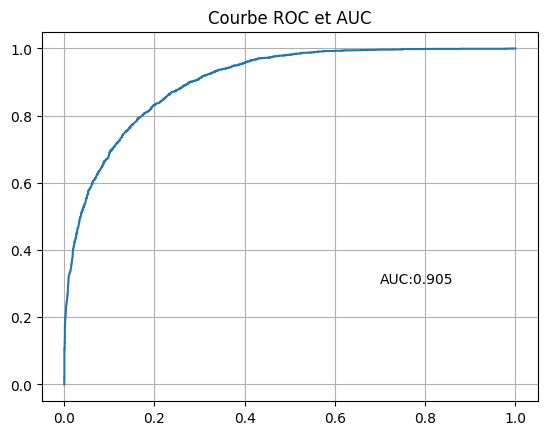

#### SCORING LOGIT ####
            Valeur  Cible
AUC       0.904824   0.80
F1-Score  0.788761   0.75
Accuracy  0.855256   0.85
MCC       0.582400   0.75
gAUC      0.879980   0.80
Score du Logit: 4


In [81]:
#####  LOGIT_V2  #####
df_V2 = pd.read_csv('files/data/data_V2.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V2)
model_logit = Logistic_Regression_V2(X_train, y_train)
df_metrics_logit = Evaluation(model_logit, X_test, y_test, True)
df_metrics_logit, score = Scoring(df_metrics_logit, True)

### ARBRE DE DECISION V2

                                Variables  Importance
0       marital-status_Married-civ-spouse    0.437928
1                            capital-gain    0.212136
2  occupation_Occupation:Very-High-income    0.158986
3                            capital-loss    0.078331
4                 education_Low-education    0.035523
5                       education_HS-grad    0.028000
6       occupation_Occupation:High-income    0.010170
7                    education_Graduation    0.008651
8                        age_(40.0, 57.0]    0.007377
9                  education_Some-college    0.005159


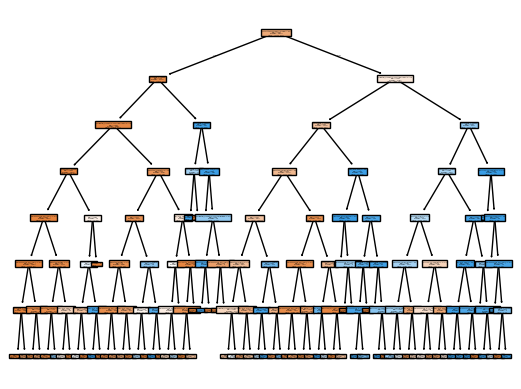

Matrice de confusion:
[[6904  527]
 [ 926 1412]]
                 False         True  accuracy    macro avg  weighted avg
precision     0.881737     0.728210  0.851264     0.804974      0.844994
recall        0.929081     0.603935  0.851264     0.766508      0.851264
f1-score      0.904790     0.660276  0.851264     0.782533      0.846271
support    7431.000000  2338.000000  0.851264  9769.000000   9769.000000


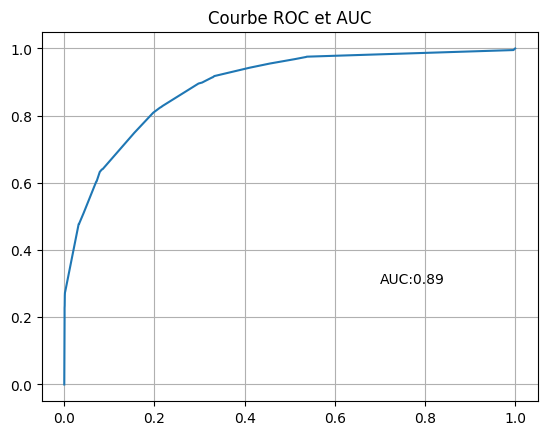

#### SCORING TREE ####
            Valeur  Cible
AUC       0.890446   0.80
F1-Score  0.782533   0.75
Accuracy  0.851264   0.85
MCC       0.570186   0.75
gAUC      0.852170   0.80
Score du Tree: 4


In [82]:
#####  ARBRE DE DÉCISION V2   #####
df_V2 = pd.read_csv('files/data/data_V2.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V2)
model_decision_tree = DecisionTree_V2(X_train, y_train)
df_metrics_tree = Evaluation(model_decision_tree, X_test, y_test, False)
df_metrics_tree, score = Scoring(df_metrics_tree, False)

## 2ème Deuxième Cycle

Dans cette deuxième partie du deuxième cycle, nous allons tenter d'optimiser les hyper-paramètres de nos modèles en utilisant la classe GridSearchCV.

La fonction GrilleRecherche permet de tester l'ensemble des combinaisons des hyper-paramètres que nous lui fournissons, pour le modèle Logit et l'arbre de décision. La fonction nous affiche le classement des 10 meilleures combinaisons d'hyper-paramètres permettant de maximiser la précision du modèle. Nous choisirons ensuite une combinaison parmi celle-ci pour construire nos derniers modèles que nous testerons ensuite grâce aux jeux de tests.

In [102]:
def GrilleRecherche(X_train, y_train, isLogit):
    """
    """
    if not isLogit:
        model = tree.DecisionTreeClassifier(random_state=42)
        # parameters = {'ccp_alpha':np.linspace(0,0.01, 10), 
        #               'criterion': ['gini', 'entropy'],
        #               'max_depth': list(range(7, 14)),
        #               'max_leaf_nodes':np.linspace(40, 60, 5, dtype = int),
        #               'min_impurity_decrease': np.linspace(0,0.5,5),
        #               'min_samples_split':np.linspace(20,60,5, dtype = int)
        #               }

        parameters = {'max_depth': list(range(7, 14)),
                    'max_leaf_nodes':np.linspace(40, 70, 10, dtype = int),
                    'min_samples_split':np.linspace(30, 60, 10, dtype = int),
                    'min_samples_leaf':np.linspace(20, 40, 10, dtype = int)
                    }
    else:
        model = LogisticRegression(random_state = 42)
        parameters = {'C':[0.001, 0.01, 0.1, 1, 10],
                      'tol':[1e-2, 1e-3, 1e-4, 1e-6],
                      'fit_intercept': [True, False],
                      'solver':['lbfgs', 'liblinear', 'newton-cholesky'],
                      'max_iter': [100, 500, 1000, 5000]}

    
    clf = GridSearchCV(model, parameters, scoring='accuracy', n_jobs=6)
    clf.fit(X_train, y_train)

    print(clf.best_params_)

    results = clf.cv_results_

    # Tri des résultats par la performance (score moyen dans les cross-validations)
    sorted_results = sorted(
    zip(results['mean_test_score'], results['params']),
    key=lambda x: x[0],
    reverse=True)

    # Sélection des 10 meilleures combinaisons
    top_10_combinaisons = sorted_results[:10]

    return top_10_combinaisons

In [103]:
df_V2 = pd.read_csv('files/data/data_V2.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V2)

In [104]:
top10_Logit = GrilleRecherche(X_train, y_train, True)

/Users/alexanderlunel/Documents/LILLE/Master/MasterSIAD/M2/Scoring/Etude de cas/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexanderlunel/Documents/LILLE/Master/MasterSIAD/M2/Scoring/Etude de cas/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to t

{'C': 10, 'fit_intercept': False, 'max_iter': 500, 'solver': 'lbfgs', 'tol': 0.0001}


/Users/alexanderlunel/Documents/LILLE/Master/MasterSIAD/M2/Scoring/Etude de cas/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
top10_tree = GrilleRecherche(X_train, y_train, False)

KeyboardInterrupt: 

In [107]:
print(f"##### LOGIT #####")
for rank, (score, params) in enumerate(top10_Logit, start=1):
    print(f"Rank {rank}: Score = {score:.4f}, Parameters = {params} \n")

##### LOGIT #####
Rank 1: Score = 0.8553, Parameters = {'C': 10, 'fit_intercept': False, 'max_iter': 500, 'solver': 'lbfgs', 'tol': 0.0001} 

Rank 2: Score = 0.8553, Parameters = {'C': 10, 'fit_intercept': False, 'max_iter': 500, 'solver': 'lbfgs', 'tol': 1e-06} 

Rank 3: Score = 0.8553, Parameters = {'C': 10, 'fit_intercept': False, 'max_iter': 500, 'solver': 'lbfgs', 'tol': 0.001} 

Rank 4: Score = 0.8551, Parameters = {'C': 0.1, 'fit_intercept': False, 'max_iter': 100, 'solver': 'newton-cholesky', 'tol': 0.01} 

Rank 5: Score = 0.8551, Parameters = {'C': 0.1, 'fit_intercept': False, 'max_iter': 100, 'solver': 'newton-cholesky', 'tol': 0.001} 

Rank 6: Score = 0.8551, Parameters = {'C': 0.1, 'fit_intercept': False, 'max_iter': 100, 'solver': 'newton-cholesky', 'tol': 0.0001} 

Rank 7: Score = 0.8551, Parameters = {'C': 0.1, 'fit_intercept': False, 'max_iter': 100, 'solver': 'newton-cholesky', 'tol': 1e-06} 

Rank 8: Score = 0.8551, Parameters = {'C': 0.1, 'fit_intercept': False, 'max

In [106]:
print(f"##### ARBRE DE DÉCISION #####")
for rank, (score, params) in enumerate(top10_tree, start=1):
    print(f"Rank {rank}: Score = {score:.4f}, Parameters = {params} \n")

##### ARBRE DE DÉCISION #####
Rank 1: Score = 0.8605, Parameters = {'max_depth': 13, 'max_leaf_nodes': np.int64(63), 'min_samples_leaf': np.int64(20), 'min_samples_split': np.int64(60)} 

Rank 2: Score = 0.8604, Parameters = {'max_depth': 13, 'max_leaf_nodes': np.int64(63), 'min_samples_leaf': np.int64(20), 'min_samples_split': np.int64(56)} 

Rank 3: Score = 0.8602, Parameters = {'max_depth': 12, 'max_leaf_nodes': np.int64(60), 'min_samples_leaf': np.int64(22), 'min_samples_split': np.int64(60)} 

Rank 4: Score = 0.8602, Parameters = {'max_depth': 12, 'max_leaf_nodes': np.int64(60), 'min_samples_leaf': np.int64(22), 'min_samples_split': np.int64(30)} 

Rank 5: Score = 0.8602, Parameters = {'max_depth': 12, 'max_leaf_nodes': np.int64(60), 'min_samples_leaf': np.int64(22), 'min_samples_split': np.int64(33)} 

Rank 6: Score = 0.8602, Parameters = {'max_depth': 12, 'max_leaf_nodes': np.int64(60), 'min_samples_leaf': np.int64(22), 'min_samples_split': np.int64(36)} 

Rank 7: Score = 0.8602

In [111]:
def Logistic_Regression_V3(X_train, y_train):
    """
    Crée le Logit et l'entraîne grâce aux datasets d'entraînement
    Avec les hyper-paramètres du GridSearchCV
    """
    model = LogisticRegression(random_state = 42, 
                               C=10,
                               fit_intercept=False,
                               max_iter = 500,
                               tol = 0.0001,
                               solver='lbfgs').fit(X_train, y_train)

    return model

def DecisionTree_V3(X_train, y_train):
    """
    Créer l'arbre de décision et l'entraîne grâce aux datasets d'entraînement
    Avec les hyper-paramètres du GridSearchCV
    """
    model = tree.DecisionTreeClassifier(random_state = 42,
                                        max_depth=13,
                                        max_leaf_nodes=63,
                                        min_samples_leaf=20, 
                                        min_samples_split=60).fit(X_train, y_train)

    return model

### LOGIT V3

/Users/alexanderlunel/Documents/LILLE/Master/MasterSIAD/M2/Scoring/Etude de cas/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Intercept [0.]
                                 Variables  Coefficients  Odd-Ratios
10                    education_Graduation      1.085613    2.961254
28                       relationship_Wife      1.076821    2.935334
16       marital-status_Married-civ-spouse      0.914186    2.494743
40                        age_(40.0, 57.0]      0.585723    1.796290
13                       education_Masters      0.577447    1.781485
21  occupation_Occupation:Very-High-income      0.382197    1.465501
45             hours-per-week_(43.0, 52.0]      0.343782    1.410271
9                      education_Bachelors      0.328145    1.388391
41                        age_(57.0, 90.0]      0.327577    1.387601
39                        age_(33.0, 40.0]      0.305301    1.357033
Matrice de confusion:
[[6928  503]
 [ 900 1438]]
                 False         True  accuracy    macro avg  weighted avg
precision     0.885028     0.740855  0.856382     0.812942      0.850523
recall        0.932311     0.61

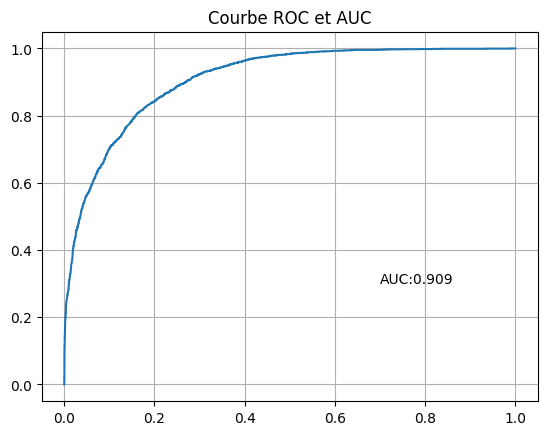

#### SCORING LOGIT ####
            Valeur  Cible
AUC       0.908898   0.80
F1-Score  0.790087   0.75
Accuracy  0.856382   0.85
MCC       0.585310   0.75
gAUC      0.885482   0.80
Score du Logit: 4


In [112]:
#####  LOGIT_V3  #####
df_V2 = pd.read_csv('files/data/data_V2.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V2)
model_logit = Logistic_Regression_V3(X_train, y_train)
df_metrics_logit = Evaluation(model_logit, X_test, y_test, True)
df_metrics_logit, score = Scoring(df_metrics_logit, True)

### ARBRE DE DECISION V3

                                Variables  Importance
0       marital-status_Married-civ-spouse    0.424356
1                            capital-gain    0.205064
2  occupation_Occupation:Very-High-income    0.154058
3                            capital-loss    0.070877
4                 education_Low-education    0.034422
5                       education_HS-grad    0.026861
6                        age_(40.0, 57.0]    0.014369
7                    education_Graduation    0.009961
8       occupation_Occupation:High-income    0.009855
9                        age_(23.0, 28.0]    0.008375


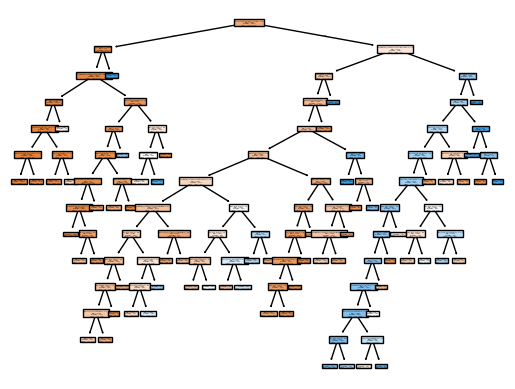

Matrice de confusion:
[[7049  382]
 [ 996 1342]]
                 False         True  accuracy    macro avg  weighted avg
precision     0.876196     0.778422  0.858942     0.827309      0.852796
recall        0.948594     0.573995  0.858942     0.761294      0.858942
f1-score      0.910959     0.660758  0.858942     0.785859      0.851079
support    7431.000000  2338.000000  0.858942  9769.000000   9769.000000


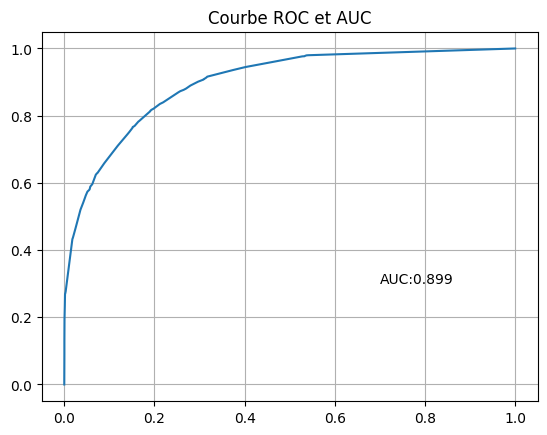

#### SCORING TREE ####
            Valeur  Cible
AUC       0.898523   0.80
F1-Score  0.785859   0.75
Accuracy  0.858942   0.85
MCC       0.584890   0.75
gAUC      0.867505   0.80
Score du Tree: 4


In [113]:
#####  ARBRE DE DÉCISION V2   #####
df_V2 = pd.read_csv('files/data/data_V2.csv')
X_train, X_test, y_train, y_test = Create_Train_Test(df_V2)
model_decision_tree = DecisionTree_V3(X_train, y_train)
df_metrics_tree = Evaluation(model_decision_tree, X_test, y_test, False)
df_metrics_tree, score = Scoring(df_metrics_tree, False)